# Emojify - Sentiment Analysis of Text
Authors: *Matteo Pozzan, Giovanni Vedana*

In this project, we want to implement a system that can summarize the *sentiment* of a written sentence and map it into an *emoji*.

In [1]:
pip install emojii

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement emojii (from versions: none)
ERROR: No matching distribution found for emojii


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matte\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
##################################################
# Imports
##################################################
import cv2
import os
import matplotlib.pyplot as plt
import emoji
import numpy as np
import pandas as pd
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from nltk.stem import PorterStemmer
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# Dataset
https://www.kaggle.com/c/emojify-challenge/data <br>
188 phrases, 312 words, 5 classes of emoji

In [4]:


train=pd.read_csv('./train.csv')                        #100 phrases
val=pd.read_csv('./validation.csv')                     #32  phrases
test=pd.read_csv('./sample_submission.csv')             #56  phrases
test['phrase'] = test['phrase'].str.replace('\t', '')

y_train = train['class']                                
y_val = val['class']


def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)

emoji_dictionary = {
    '0': '\u2764\uFE0F',
    '1': ':baseball:',
    '2': ':smile:',
    '3': ':disappointed:',
    '4': ':fork_and_knife:'
}

# See some data examples
print('EXAMPLES:\n####################')
for idx in range(10):
    print(f'{train["phrase"][idx]} -> {label_to_emoji(y_train[idx])}')

EXAMPLES:
####################
I want to go play -> ⚾
I want to have sushi for dinner -> 🍴
I am always working -> 😞
she is happy -> 😄
What is wrong with you -> 😞
I am proud of your achievements -> 😄
funny -> 😄
do you like pizza  -> 🍴
no one likes him -> 😞
he is the best player -> ⚾


The number of *unique* words in training and validation set.

In [5]:
train.phrase=[phrase.lower() for phrase in train.phrase]

words_train=[]
for phrase in train.phrase:
    words_train+=word_tokenize(phrase)
    
val.phrase=[phrase.lower() for phrase in val.phrase]

words_val=[]
for phrase in val.phrase:
    words_val+=word_tokenize(phrase)

print('Number of (unique) words in the training set: {}'.format(len(set(words_train))))
print('Number of (unique) words in the validation set: {}'.format(len(set(words_val))))
print('Number of words that are in the validation set but not in the training set: {}'.format(len(set(words_val)-set(words_train))))

Number of (unique) words in the training set: 210
Number of (unique) words in the validation set: 103
Number of words that are in the validation set but not in the training set: 49


## Exploratory Data Analysis

How many times a does word occur in the training phrases? -> **long-tail distribution**

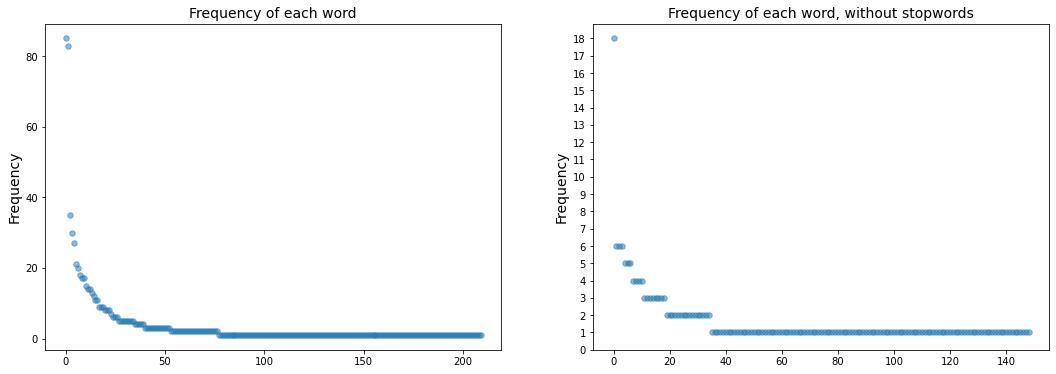

In [6]:
train.phrase=[phrase.lower() for phrase in train.phrase]

words=[]
for phrase in train.phrase:
    words+=word_tokenize(phrase)

frequency={word:0 for word in list(set(words))}
for word in list(set(words)):
    for phrase in train.phrase:
        if word in phrase:
            frequency[word]+=1    


frequency2={word:0 for word in list(set(words)-set(ENGLISH_STOP_WORDS))}
for word in list(set(words)-set(ENGLISH_STOP_WORDS)):
    for phrase in train.phrase:
        if word in phrase:
            frequency2[word]+=1  
            
fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].scatter( range(len(frequency.values())), sorted(frequency.values(), reverse=True), s=30, alpha=0.5)
ax[0].set_ylabel('Frequency', fontsize=14)
ax[0].set_title('Frequency of each word', fontsize=14)
ax[1].scatter( range(len(frequency2.values())), sorted(frequency2.values(), reverse=True), s=30, alpha=0.5)
ax[1].set_ylabel('Frequency', fontsize=14)
ax[1].set_yticks(range(19))
ax[1].set_title('Frequency of each word, without stopwords', fontsize=14)
plt.show()

Wordcloud with the most frequent words in the training set.

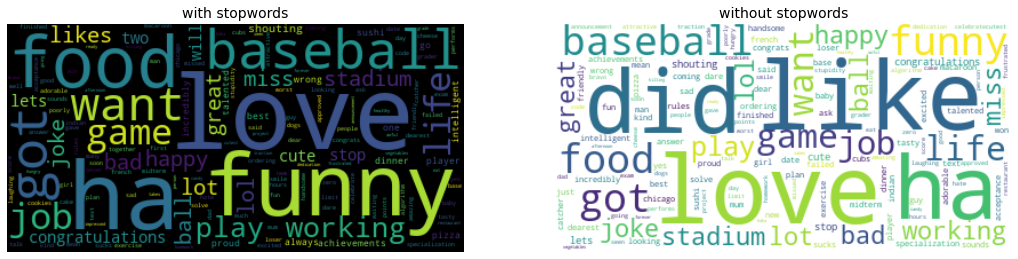

In [7]:
phrases = ''
for phrase in train.phrase.values:
    phrases+= ' '+phrase

from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(18,10))
cloud_phrases = WordCloud().generate(phrases)
cloud_phrases2 = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white').generate(phrases)
ax[0].imshow(cloud_phrases, interpolation='bilinear')
ax[1].imshow(cloud_phrases2, interpolation='bilinear')
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('with stopwords', fontsize=14)
ax[1].set_title('without stopwords', fontsize=14)
plt.show()

Let's see if the classes are *balanced*, i.e. the class distribution of the training samples is close to equal -> they are **not balanced**, class 2 and 3 are more predominant.

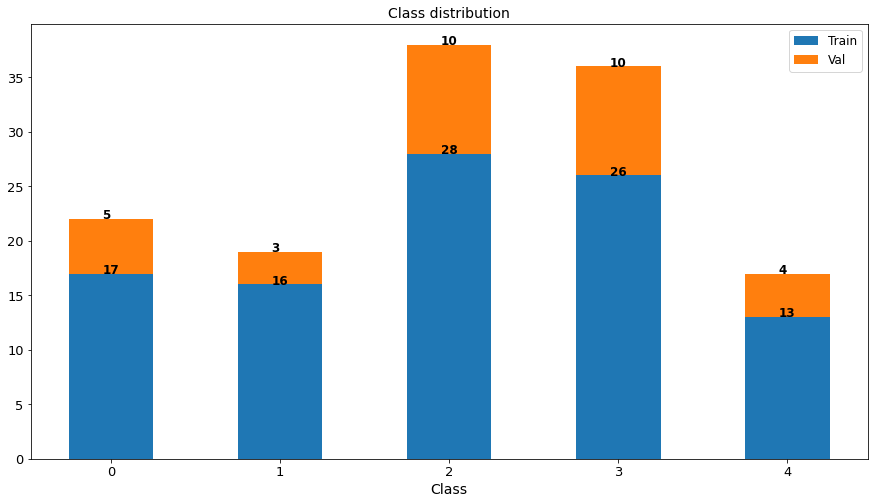

In [8]:
plt.figure(figsize=(15,8))

#plt.style.use('seaborn')

plt.bar([0,1,2,3,4], train.groupby('class').count().values.flatten(), width=0.5)

plt.bar([0,1,2,3,4], val.groupby('class').count().values.flatten(), width=0.5,
             bottom=train.groupby('class').count().values.flatten())

for i, v in enumerate(train.groupby('class').count().values.flatten()):
    plt.text(i-0.05, v, str(v), color='black', size=12, fontweight='bold')

for i, v in enumerate(val.groupby('class').count().values.flatten()):
    plt.text(i-0.05, v+train.groupby('class').count().values.flatten()[i], str(v), size=12, color='black', fontweight='bold')


plt.xlabel('Class', fontsize=14)
plt.title('Class distribution', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(('Train', 'Val'), fontsize=12)

plt.show()

### Featurization techniques
We try to use two different approaches: 
* Bag of Words -> *TF-IDF vectorizer* 
* Word Embedding -> *GloVe*

# TF-IDF
*TF-IDF* is a statistical measure that evaluates how *relevant* a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents. <br>
TfidfVectorizer converts a collection of raw documents to a matrix of TF-IDF features. <br>
We have seen that the most frequent words in the training set are stopwords. For this reason, we remove them to have less noise. <br>
We choose to take into account unigrams and bigrams.

In [9]:
vect=TfidfVectorizer(ngram_range=(1,2), stop_words=ENGLISH_STOP_WORDS) #stop_words=ENGLISH_STOP_WORDS: stopwords are removed from the phrases
                                                                       # ngram_range=(1,2): we take into account unigrams and bigrams
vect.fit(train.phrase)

X_train=pd.DataFrame(vect.transform(train.phrase).toarray(), columns=vect.get_feature_names())
X_val=pd.DataFrame(vect.transform(val.phrase).toarray(), columns=vect.get_feature_names())
X_test=pd.DataFrame(vect.transform(test.phrase).toarray(), columns=vect.get_feature_names())


y_train=train['class']
y_val=val['class']

In [10]:
X_train.head()

,acceptance,achievements,adorable,afternoon,algorithm,algorithm performs,amazing,amazing job,announcement,announcement got,...,want play,want sushi,won,working,working grader,worst,worst day,wrong,yes,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.604323,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.459404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Models


### Linear SVC 
The first model that we use is Suppor Vector Machine with linear kernel, therefore it should work well if the classes are linearly separable.  <br>
Support Vector Machines can be very much effective in sentiment clarification because we already removed some noise (stop words) and SVM should give a little weight to outliners.  <br>
Norm used in the penalization: L2. <br>
Loss function: squared hinge. <br>
Multi-class strategy: One versus Rest.  <br>

**Tuning of C** (regularization parameter). <br>
The strength of the regularization is inversely proportional to C. 

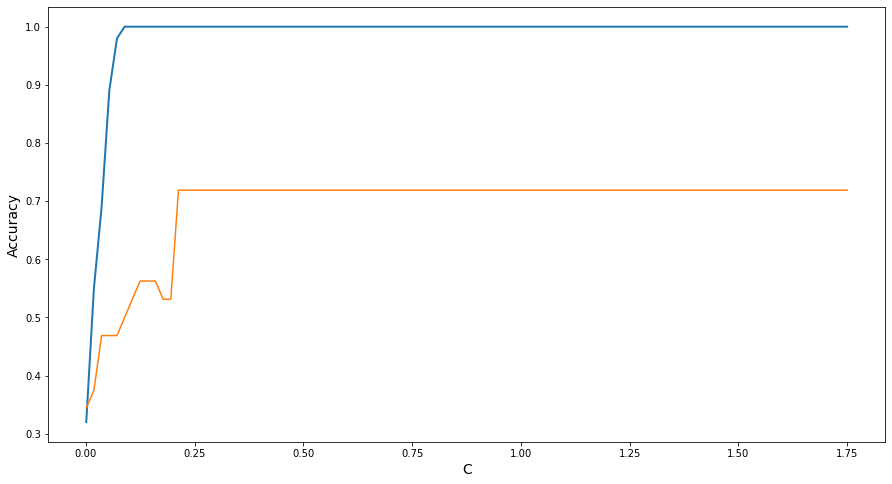

In [11]:
scores_train=[]
scores_val=[]
C=np.linspace(0.001, 1.75, 100)

for c in C:
    svc=LinearSVC(penalty='l2', loss='squared_hinge', multi_class='ovr', C=c, max_iter=10000)
    svc.fit(X_train, y_train)
    svc.predict(X_val)
    scores_val.append(svc.score(X_val, y_val))
    scores_train.append(svc.score(X_train, y_train))   

plt.figure(figsize=(15,8))
plt.plot(C, scores_train, '-', label='line 1', linewidth=2)
plt.plot(C, scores_val, '-',  label='line 2')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('C', fontsize=14)
plt.title('', fontsize=14)
plt.show()
plt.show()

It results that with a higher regularization, the model performs badly.
Moreover, with C>0.2, the training accuracy is always 1 and the validation accuracy is always 0.71875.

In [12]:
svc=LinearSVC(penalty='l2', loss='squared_hinge', multi_class='ovr', C=0.21)
svc.fit(X_train, y_train)
svc.predict(X_val)
print("Train accuracy: {}".format(svc.score(X_train, y_train)))
print("Val accuracy: {}".format(svc.score(X_val, y_val)))

Train accuracy: 1.0
Val accuracy: 0.71875


*Which phrases are hard to classify for the classifier?*

In [13]:
y_predicted=svc.predict(X_val)
mask=[True if x!=0 else False for x in np.array(y_predicted)-y_val.values]
val[mask]

,phrase,class
1,i got humiliated by my sister,3
2,she smiles a lot,2
7,lets brunch some day,4
8,i cooked meat,4
9,my dog just had a few puppies,0
16,who is playing in the final,1
17,he had to make a home run,1
20,we made it,2
30,do you want to give me a hug,0


7 phrases out of 10 have class 0,1,4: the less frequent in the training set.

In [14]:
svc.predict(X_test)

array([4, 3, 2, 2, 2, 4, 3, 4, 4, 2, 1, 3, 3, 3, 1, 3, 3, 0, 3, 4, 0, 3,
       3, 3, 3, 3, 1, 0, 1, 3, 0, 1, 2, 2, 3, 3, 3, 4, 4, 2, 3, 2, 0, 1,
       2, 0, 3, 2, 2, 3, 3, 3, 1, 2, 3, 3], dtype=int64)

### Others Classifiers
We compare the results obtained from a bunch of popular classifiers to see which is the best. <br>
We have previously done a hyperparameter tuning for each model.

In [15]:
models = {'LinearSVC': LinearSVC(penalty='l2', loss='squared_hinge', multi_class='ovr', C=1), 'kNN':KNeighborsClassifier(algorithm='brute', n_neighbors=2), 
          'MNB':MultinomialNB(alpha=0.42),
          'Tree':DecisionTreeClassifier(criterion='entropy', random_state=1), 'LogReg':LogisticRegression(C=33, multi_class='ovr') }

for name, model in models.items():
    model.fit(X_train, y_train)
    model.predict(X_val)
    print(name)
    print("Train accuracy: {}".format(model.score(X_train, y_train)))
    print("Val accuracy: {}".format(model.score(X_val, y_val)))
    print('')
print('')

LinearSVC
Train accuracy: 1.0
Val accuracy: 0.71875

kNN
Train accuracy: 0.88
Val accuracy: 0.46875

MNB
Train accuracy: 1.0
Val accuracy: 0.5625

Tree
Train accuracy: 1.0
Val accuracy: 0.625

LogReg
Train accuracy: 1.0
Val accuracy: 0.71875




Comparing these values,  we can see that with *Linear SVC* and *Logistic Regression* the higher accuracy is reached.

# GloVe
*GloVe* is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. <br>
Words can be represented as n-dimensional vectors where the distance between points has correspondence for the similarity between word semantics (similar words are closer, while dissimilar ones are distant). This representation is known as word embeddings and here is extrapolated and pre-computed from the [GloVe](https://nlp.stanford.edu/projects/glove/) model. <br>
In our case, a single word is represented by a vector of length 25. <br>
All the phrases are padded to the phrase of maximum length, in this case, `max_len = 10`, and each phrase is represented by the concatenation of his word embeddings (each phrase thus is a 10 * 25 = 250 dimensional vector).

*Phrase representation*

In [16]:
X_train_gv = np.load('./train.npy').reshape(len(train), -1)
X_val_gv = np.load('./validation.npy').reshape(len(val), -1)
X_test_gv = np.load('./test.npy').reshape(56,-1)
X_gv=np.append(X_train_gv, X_val_gv, axis=0)
y=np.append(y_train, y_val)

#### Visualization in a 2D space

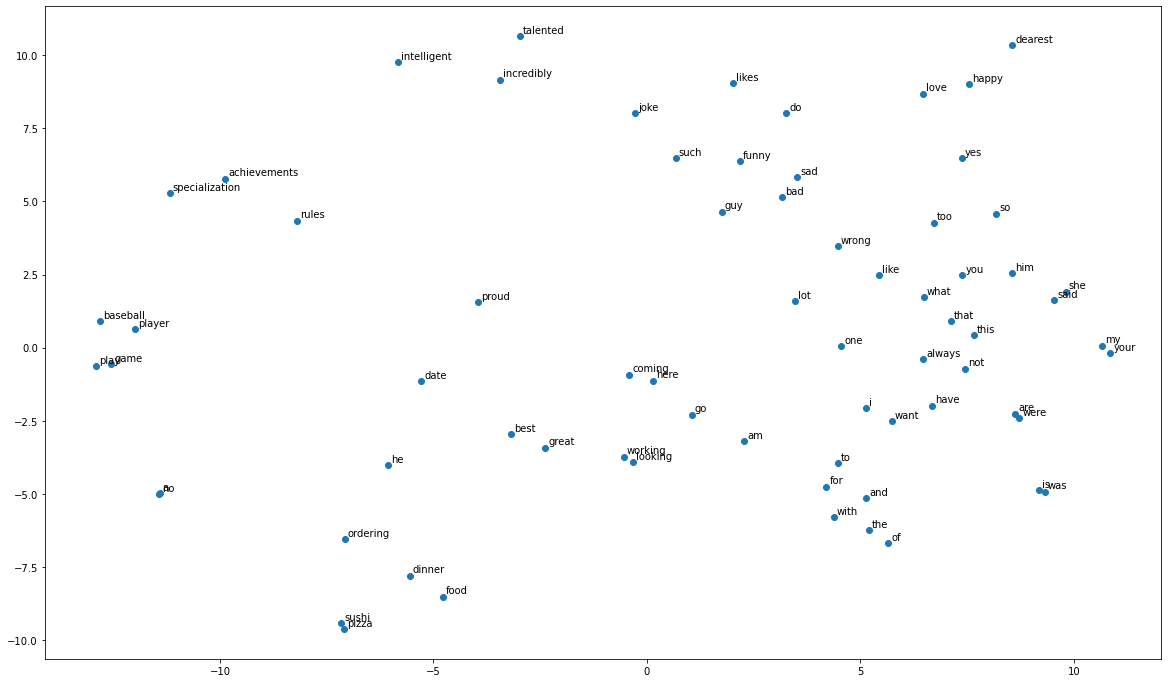

In [17]:
from sklearn.manifold import TSNE

train_array = np.load('./train.npy')

word_tokens = [word_tokenize(x) for x in train.phrase]
word_tokens[0][0]

embeddings_dict={}
for i in range(len(word_tokens)):
    for j in range(len(word_tokens[i])):
        embeddings_dict[word_tokens[i][j]] = [x for x in train_array[i,j]]
        
tsne = TSNE(n_components=2, random_state=0) #To visualize the vectors in a 2-dim space we reduced the dimension of each word-vectors from 25 to 2
words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]
X_embedded = tsne.fit_transform(vectors)

plt.figure(figsize=(20,12))
plt.scatter(X_embedded[:70,0], X_embedded[:70,1])
for label, x, y in zip(words, X_embedded[:70,0], X_embedded[:70,1]):
    plt.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
plt.show()
        

In this case, stopwords are kept: global vectors capture the meaning of a word depending on the context, so they could be meaningful.

## Models


### kNN
We focused on *K-Nearest Neighbors* at first because it assigns to the same class word-vectors that are close. Due to the GloVe representations, they could work well together. 

**Hyperparameters tuning**

In [18]:
n_neighbors=[1,2,3,4,5]
metric=['manhattan', 'minkowski', 'chebyshev']
weights=['uniform', 'distance']

accuracies=[]
for n in n_neighbors:
    for m in metric:
        for w in weights:
            knn=KNeighborsClassifier(n_neighbors=n, metric=m, weights=w)
            knn.fit(X_train, y_train)
            knn.predict(X_val)
            accuracies.append(knn.score(X_val, y_val))
print("Max val accuracy: {}".format(max(accuracies)))

Max val accuracy: 0.625


### Other Classifiers
As we did with Tfidf, we also tried a bunch of different classifiers to see if we find a better accuracy. <br>
We used *SVC*, *LinearSVC*, *Decision Tree*, *Logistic Regression*. <br>
Here there are the results with the optimal hyperparameters.

In [19]:
models = {'SVC': SVC(max_iter=10000, kernel='rbf', C=268.2695795279727, decision_function_shape='ovo', gamma=0.001),'LinearSVC': LinearSVC(max_iter=10000, penalty='l2', loss='squared_hinge', multi_class='ovr', C=1),  
          'Tree':DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=6, splitter='random'), 'LogReg':LogisticRegression(C=0.2, multi_class='ovr', max_iter=10000, solver='saga')}

for name, model in models.items():
    model.fit(X_train_gv, y_train)
    model.predict(X_val_gv)
    print(name)
    print("Train accuracy: {}".format(model.score(X_train_gv, y_train)))
    print("Val accuracy: {}".format(model.score(X_val_gv, y_val)))
    print('')

SVC
Train accuracy: 1.0
Val accuracy: 0.625

LinearSVC
Train accuracy: 1.0
Val accuracy: 0.5

Tree
Train accuracy: 0.83
Val accuracy: 0.5625

LogReg
Train accuracy: 0.99
Val accuracy: 0.65625



The best accuracy is obtained with *Logistic Regression*. Besides, the performance of the models is worst using GloVe instead of TfIdf, even if GloVe seems a more powerful word vectorization.

Lastly, we try to solve the Emojify problem with the use of the Neural Networks with **Keras**.  <br>
They could be very effective because NN is a stronger classifier that could capture better the interaction and the connections of the features.  <br>
Like we did before, we used as word vectorization *TfidfVectorizer*, and then *GloVe*, comparing the results.

# NEURAL NETWORKS
N.B. the cells below take half an hour to run due to their great computation cost

We tried to solve the Emojify problem with the use of the Neural Networks with **Keras**. Firstly we created some networks with the word vectorization obtained with the **TfidfVectorizer**, and then we trained the same networks with the vectorization with **GloVe**, comparing the results.

In [20]:
###########
#  Imports
###########

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Activation
from keras.utils import to_categorical
from tensorflow.keras import initializers
import tensorflow as tf

**WEIGHTS INITIALIZATION** In all the following models we will initialize weights according to a **Normal** random variable, and we set the initial bias to 0.

**LOSS FUNCTION** We chose the **Categorical cross-entropy** as the loss function.

**ACTIVATION FUNCTION** We used the **softmax** activation as the activation function for the output layer since it provides the probability to be in a particular class. For what concerns the activation in the hidden layers we looked for the best function in our trials: we noticed that the **Relu** is the one that behaves better in our models.

**DROPOUT** In every model we used the Dropout to prevent overfitting: we tried several dropout rates and in this case, a good rate is slight **less than 0.5** (we report here only the verification changing the dropout rate on the best model).

**BATCH SIZE** In the propagation we used a **Batch Gradient Descent** with a batch size of 32: we chose this number after some trials that are not reported in this Notebook since we decided to focus on other hyperparameters.

**NUMBER OF NEURONS** We will search for the optimal number of neurons looking between the **powers of 2** from 32 to 1024.

**NUMBER OF LAYERS** We will look for the best number of layers: the optimal number is not constant and depends on the number of neurons for each layer.

**BATCH NORMALIZATION** We tried also to add **Batch Normalization** layers but they did not lead to a better model (we do not report here these trials).

**EPOCHS** We observed that the optimal number of epochs is always **less than 40** for these models.


In [21]:
# Due to the use of the softmax, the outputs will be the probabilities of belong to a particular label, so we have to write the 
# labels as binary vectors, with a 1 in correspondence of the index of the original label

y_train2 = pd.Categorical(y_train)
y_train2 = to_categorical(y_train2)

y_val2 = pd.Categorical(y_val)
y_val2 = to_categorical(y_val2)

## Word vectorization with TFIDF

### One Hidden Layer

We begin looking at the Neural Network with only one hidden layer, and we compare the accuracies and the loss function changing the number of neurons.

In [22]:
nn = [32, 64, 128, 256, 512, 1024]
accuracies = {}
val_accuracies = {}
losses = {}
val_losses = {}
for n in nn:
    tf.random.set_seed(1234)
    model1 = Sequential()
    model1.add(Dense(n, input_dim = 247, activation = 'relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model1.add(Dropout(0.5))
    model1.add(Dense(5, activation = 'softmax'))

    model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    training = model1.fit(X_train, y_train2, validation_data=(X_val, y_val2), epochs= 40, verbose = 0)
    accuracies[n] = training.history['accuracy']
    val_accuracies[n] = training.history['val_accuracy']
    losses[n] = training.history['loss']
    val_losses[n] = training.history['val_loss']

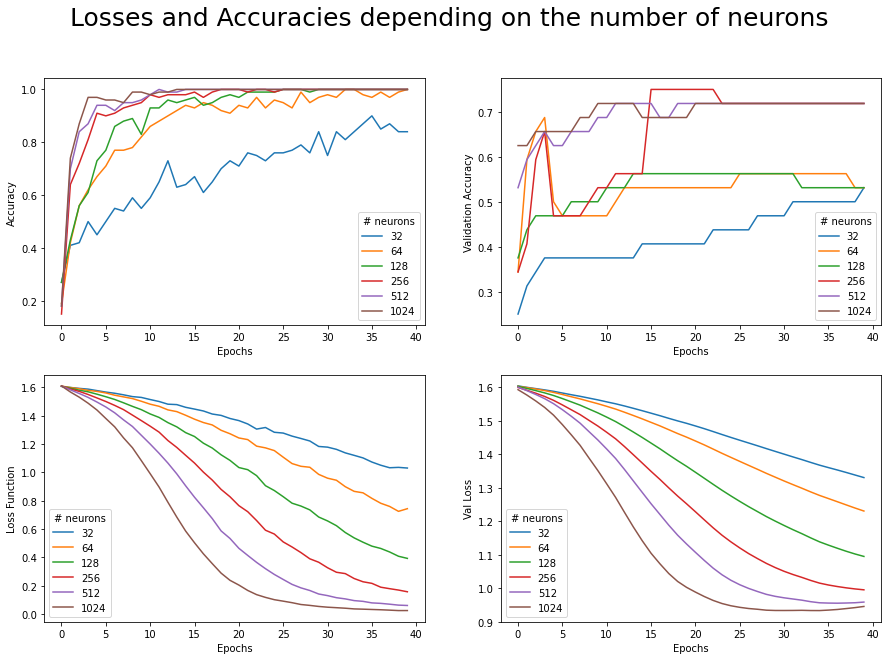

In [23]:
fig = plt.figure(figsize = (15, 10))
fig.suptitle('Losses and Accuracies depending on the number of neurons', fontsize=25)

ax1 = fig.add_subplot(2, 2, 1)

for n in nn:
    _ = plt.plot(accuracies[n])
_ = plt.legend(nn, title = '# neurons')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Accuracy')

ax2 = fig.add_subplot(2, 2, 2)
for n in nn:
    _ = plt.plot(val_accuracies[n])
_ = plt.legend(nn, title= '# neurons')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Validation Accuracy')


ax3 = fig.add_subplot(2, 2, 3)
for n in nn:
    _ = plt.plot(losses[n])
_ = plt.legend(nn, title = '# neurons')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss Function')


ax4 = fig.add_subplot(2, 2, 4)
for n in nn:
    _ = plt.plot(val_losses[n])
_ = plt.legend(nn, title = '# neurons')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Val Loss')

Looking at the previous plots it seems that we need to use a model with a large number of neurons

In [24]:
print('The best validation accuracy is ' + str(max([max(acc) for acc in val_accuracies.values()])))

The best validation accuracy is 0.75


### NN with different number of layers with the same number of neurons

Now we try to find a better model changing the number of layers (all with the same number of neurons) and looking if the accuracy improves by choosing different activation functions

In [25]:
def create_model2(nn, nl, activation):
    model = Sequential()
    model.add(Dense(nn, input_dim = 247, activation = activation, kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model.add(Dropout(0.4))
    for i in range(nl-1):   
        model.add(Dense(nn, activation = activation))
        model.add(Dropout(0.4))
    model.add(Dense(5, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [26]:
nn = [64, 128, 256, 512]                      ## number of neurons
nl = [1,2,3,4,5]                              ## number of layers
activations = ['tanh', 'relu', 'sigmoid']     ## activation functions  

val_accuracies2 = {}
for n in nn:
    for l in nl:
        for act in activations:
            tf.random.set_seed(1234)
            model = create_model2(nn = n, nl = l, activation = act)
            training = model.fit(X_train,y_train2, validation_data = (X_val , y_val2), epochs = 40, verbose = 0, batch_size = 32)
    
            val_accuracies2[max(training.history['val_accuracy'])] = {'nn': n, 'nl': l, 'best_epoch' : np.argmax(training.history['val_accuracy']), 'activation': act}

In [27]:
val_accuracies2

{0.75: {'nn': 512, 'nl': 5, 'best_epoch': 5, 'activation': 'tanh'},
 0.6875: {'nn': 512, 'nl': 4, 'best_epoch': 16, 'activation': 'relu'},
 0.59375: {'nn': 256, 'nl': 1, 'best_epoch': 35, 'activation': 'sigmoid'},
 0.71875: {'nn': 512, 'nl': 4, 'best_epoch': 3, 'activation': 'tanh'},
 0.5625: {'nn': 512, 'nl': 2, 'best_epoch': 13, 'activation': 'sigmoid'},
 0.375: {'nn': 512, 'nl': 3, 'best_epoch': 21, 'activation': 'sigmoid'},
 0.3125: {'nn': 512, 'nl': 5, 'best_epoch': 0, 'activation': 'sigmoid'},
 0.65625: {'nn': 512, 'nl': 5, 'best_epoch': 33, 'activation': 'relu'},
 0.53125: {'nn': 128, 'nl': 2, 'best_epoch': 36, 'activation': 'sigmoid'},
 0.5: {'nn': 128, 'nl': 3, 'best_epoch': 20, 'activation': 'sigmoid'},
 0.625: {'nn': 256, 'nl': 2, 'best_epoch': 35, 'activation': 'sigmoid'}}

In [28]:
print('The best validation accuracy is ' + str(max(val_accuracies2.keys())))

The best validation accuracy is 0.75


In this case, we noticed that is not necessary to have a Network with a large **number of layers**, so in the next example we will fix that number to be equal to 3.

Moreover, we observed that there is not an improvement using tanh or sigmoid as activation functions: in the following examples, we will consider the **relu** function since it makes the model simpler and more effective, providing great computational advantages.

### NN with different numer of neurons with 3 hidden layers

Until now we built Neural Network with layers with the same dimension, now we observe what happens if we change the number of neurons for each layer, and we see that this approach leads to better results.

In [29]:
def create_model3(nn1, nn2, nn3):
    model = Sequential()
    model.add(Dense(nn1, input_dim = 247, activation = 'relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model.add(Dropout(0.4))
    model.add(Dense(nn2, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(nn3, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [30]:
val_accuracies3 = {}

for n1 in nn:
    for n2 in nn:
        for n3 in nn:
            tf.random.set_seed(1234)
            model = create_model3(nn1 = n1, nn2 = n2, nn3 = n3)
            training = model.fit(X_train,y_train2, validation_data=(X_val, y_val2), epochs= 40, verbose = 0, batch_size = 32)
    
            val_accuracies3[max(training.history['val_accuracy'])] = {'nn1': n1, 'nn2': n2,'nn3': n3,'best_epoch' : np.argmax(training.history['val_accuracy'])}

In [31]:
val_accuracies3

{0.71875: {'nn1': 512, 'nn2': 512, 'nn3': 128, 'best_epoch': 15},
 0.75: {'nn1': 512, 'nn2': 512, 'nn3': 512, 'best_epoch': 10},
 0.78125: {'nn1': 256, 'nn2': 512, 'nn3': 512, 'best_epoch': 13}}

In [32]:
print('The best validation accuracy is ' + str(max(val_accuracies3.keys())))

The best validation accuracy is 0.78125


In [33]:
# Best Network found until now
tf.random.set_seed(1234)
best_model_tfidf = create_model3(256, 512, 512)
training_tf = best_model_tfidf.fit(X_train,y_train2, validation_data=(X_val, y_val2), epochs= 14, verbose = 0, batch_size = 32)

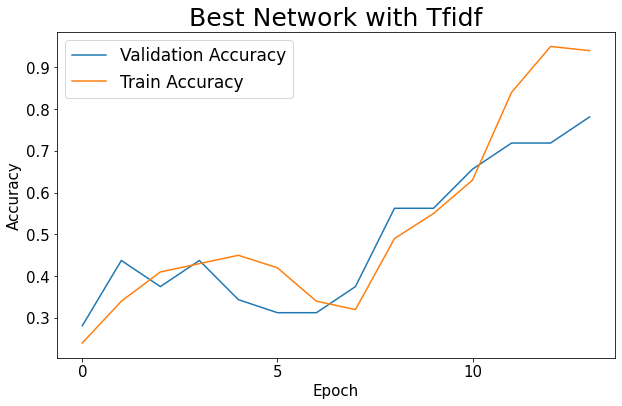

In [34]:
fig = plt.figure(figsize = (10, 6))
_ = plt.plot(training_tf.history['val_accuracy'])
_ = plt.plot(training_tf.history['accuracy'])
_ = plt.xlabel('Epoch', fontsize = 15)
_ = plt.ylabel('Accuracy', fontsize = 15)
_ = plt.yticks(fontsize = 15)
_ = plt.xticks([0, 5, 10], fontsize = 15)
_ = plt.legend(['Validation Accuracy','Train Accuracy' ], fontsize = 17)
_ = plt.title('Best Network with Tfidf', fontdict = {'fontsize' : 25})

We saw an improvement in the accuracy by changing some hyperparameters in our models, but we think we can find a better network changing the word vectorization.

## Word vectorization with GloVe

We try the models built before with the word embedding with GloVe: we think that this approach could perform better than the previous one because GloVe takes into account more information than TFIDF about the **interactions** between different words (TFIDF considers only the frequency of the words in the documents)

### One Hidden Layer

In [35]:
nn = [32, 64, 128, 256, 512]
accuracies2 = {}
val_accuracies2 = {}
losses2 = {}
val_losses2 = {}
for n in nn:
    tf.random.set_seed(1234)
    model = Sequential()
    model.add(Dense(n, input_dim= 250, activation = 'relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation = 'softmax'))

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    training = model.fit(X_train_gv,y_train2, validation_data=(X_val_gv, y_val2), epochs= 40, verbose = 0)
    accuracies2[n] = training.history['accuracy']
    val_accuracies2[n] = training.history['val_accuracy']
    losses2[n] = training.history['loss']
    val_losses2[n] = training.history['val_loss']

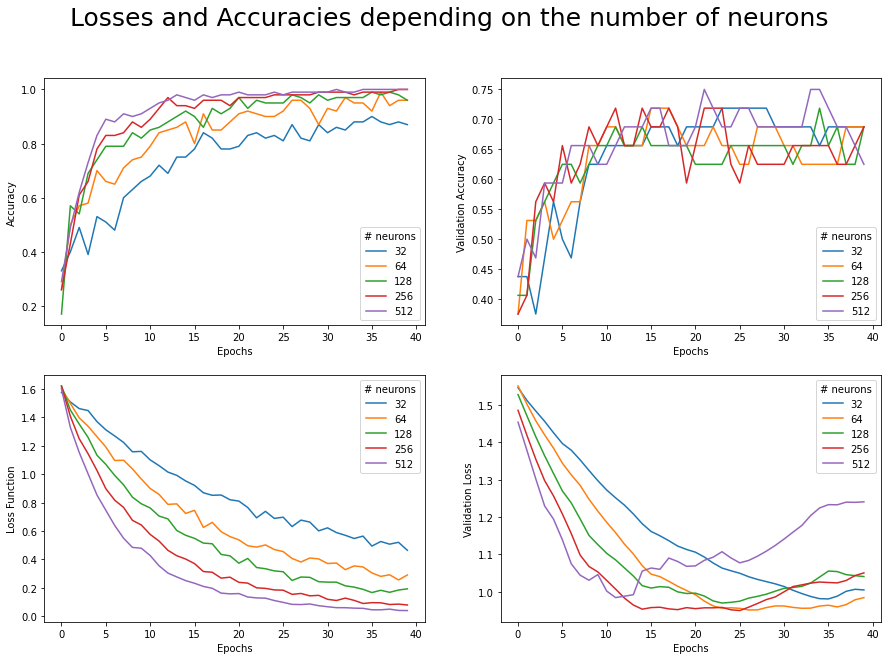

In [36]:
fig = plt.figure(figsize = (15, 10))
fig.suptitle('Losses and Accuracies depending on the number of neurons', fontsize=25)

ax1 = fig.add_subplot(2, 2, 1)

for n in nn:
    _ = plt.plot(accuracies2[n])
_ = plt.legend(nn, title = '# neurons')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Accuracy')

ax2 = fig.add_subplot(2, 2, 2)
for n in nn:
    _ = plt.plot(val_accuracies2[n])
_ = plt.legend(nn, title= '# neurons')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Validation Accuracy')


ax3 = fig.add_subplot(2, 2, 3)
for n in nn:
    _ = plt.plot(losses2[n])
_ = plt.legend(nn, title = '# neurons')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss Function')


ax4 = fig.add_subplot(2, 2, 4)
for n in nn:
    _ = plt.plot(val_losses2[n])
_ = plt.legend(nn, title = '# neurons')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Validation Loss')


In [37]:
print('The best validation accuracy is ' + str(max([max(acc) for acc in val_accuracies2.values()])))

The best validation accuracy is 0.75


### NN with different numer of layers with the same number of neurons

In [38]:
def create_model4(nn, nl):
    model = Sequential()
    model.add(Dense(nn, input_dim = 250, kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    for i in range(nl-1):   
        model.add(Dense(nn))
        model.add(Activation('relu'))
        model.add(Dropout(0.4))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [39]:
nn = [32,64,128,256,512]
nl = [1,2,3 , 4]

val_accuracies4 = {}
for n in nn:
    for l in nl:
        tf.random.set_seed(1234)
        model = create_model4(nn = n, nl = l)
        training = model.fit(X_train_gv,y_train2, validation_data=(X_val_gv, y_val2), epochs= 40, verbose = 0, batch_size = 32)
    
        val_accuracies4[max(training.history['val_accuracy'])] = {'nn': n, 'nl': l,'best_epoch' : np.argmax(training.history['val_accuracy'])}

In [40]:
val_accuracies4

{0.71875: {'nn': 256, 'nl': 2, 'best_epoch': 10},
 0.65625: {'nn': 32, 'nl': 2, 'best_epoch': 28},
 0.53125: {'nn': 32, 'nl': 3, 'best_epoch': 32},
 0.5625: {'nn': 32, 'nl': 4, 'best_epoch': 9},
 0.6875: {'nn': 256, 'nl': 4, 'best_epoch': 18},
 0.59375: {'nn': 64, 'nl': 4, 'best_epoch': 37},
 0.75: {'nn': 512, 'nl': 4, 'best_epoch': 14},
 0.78125: {'nn': 512, 'nl': 3, 'best_epoch': 31}}

In [41]:
print('The best validation accuracy is ' + str(max(val_accuracies4.keys())))

The best validation accuracy is 0.78125


The best accuracy obtained by **fixing the number of neurons** for each layer is less than what we had already found: so we expect to find a better model **changing the dimension** of each layer.

### NN with different numer of neurons with 3 hidden layers

In [42]:
def create_model5(nn1, nn2, nn3, activation):
    model = Sequential()
    model.add(Dense(nn1, input_dim = 250, activation = activation, kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model.add(Dropout(0.4))
    model.add(Dense(nn2, activation = activation))
    model.add(Dropout(0.4))
    model.add(Dense(nn3, activation = activation))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [43]:
# Using relu
nn = [32, 64, 128, 256, 512, 1024]
val_accuracies5 = {}
for n1 in nn:
    for n2 in nn:
        for n3 in nn:
            tf.random.set_seed(1234)
            model = create_model5(nn1 = n1, nn2 = n2, nn3 = n3, activation = 'relu')
            training = model.fit(X_train_gv,y_train2, validation_data=(X_val_gv, y_val2), epochs= 40, verbose = 0, batch_size = 32)
    
            val_accuracies5[max(training.history['val_accuracy'])] = {'nn1': n1, 'nn2': n2,'nn3': n3,'act': 'relu','epoch' : np.argmax(training.history['val_accuracy'])}

In [44]:
val_accuracies5

{0.53125: {'nn1': 32, 'nn2': 32, 'nn3': 32, 'act': 'relu', 'epoch': 32},
 0.625: {'nn1': 64, 'nn2': 32, 'nn3': 64, 'act': 'relu', 'epoch': 19},
 0.65625: {'nn1': 256, 'nn2': 32, 'nn3': 32, 'act': 'relu', 'epoch': 29},
 0.6875: {'nn1': 1024, 'nn2': 64, 'nn3': 32, 'act': 'relu', 'epoch': 15},
 0.59375: {'nn1': 32, 'nn2': 64, 'nn3': 256, 'act': 'relu', 'epoch': 38},
 0.71875: {'nn1': 1024, 'nn2': 1024, 'nn3': 512, 'act': 'relu', 'epoch': 7},
 0.75: {'nn1': 1024, 'nn2': 1024, 'nn3': 1024, 'act': 'relu', 'epoch': 20},
 0.8125: {'nn1': 64, 'nn2': 1024, 'nn3': 128, 'act': 'relu', 'epoch': 22},
 0.78125: {'nn1': 1024, 'nn2': 128, 'nn3': 512, 'act': 'relu', 'epoch': 23}}

In [45]:
# Using tanh
nn = [64, 128, 256,1024]
val_accuracies6 = {}
for n1 in nn:
    for n2 in nn:
        for n3 in nn:
            tf.random.set_seed(1234)
            model = create_model5(nn1 = n1, nn2 = n2, nn3 = n3, activation = 'tanh')
            training = model.fit(X_train_gv,y_train2, validation_data=(X_val_gv, y_val2), epochs= 40, verbose = 0, batch_size = 32)
    
            val_accuracies6[max(training.history['val_accuracy'])] = {'nn1': n1, 'nn2': n2,'nn3': n3,'act': 'tanh','epoch' : np.argmax(training.history['val_accuracy'])}

In [46]:
val_accuracies6

{0.75: {'nn1': 1024, 'nn2': 1024, 'nn3': 1024, 'act': 'tanh', 'epoch': 21},
 0.71875: {'nn1': 1024, 'nn2': 1024, 'nn3': 256, 'act': 'tanh', 'epoch': 18},
 0.6875: {'nn1': 1024, 'nn2': 256, 'nn3': 128, 'act': 'tanh', 'epoch': 11},
 0.78125: {'nn1': 256, 'nn2': 64, 'nn3': 1024, 'act': 'tanh', 'epoch': 21}}

In [47]:
print('The best validation accuracy is ' + str(max(val_accuracies3.keys())))

The best validation accuracy is 0.78125


### Standardization of the features with GloVe

Now we try the previous model with a standardization of the features

In [48]:
X_train_std = (X_train_gv - np.mean(X_train_gv))/np.std(X_train_gv)
X_val_std = (X_val_gv - np.mean(X_val_gv))/np.std(X_val_gv)

In [49]:
val_accuracies_std = {}
for n1 in nn:
    for n2 in nn:
        for n3 in nn:
            tf.random.set_seed(1234)
            model = create_model5(nn1 = n1, nn2 = n2, nn3 = n3, activation = 'relu')
            training = model.fit(X_train_std,y_train2, validation_data=(X_val_std, y_val2), epochs= 40, verbose = 0, batch_size = 32)
    
            val_accuracies_std[max(training.history['val_accuracy'])] = {'nn1': n1, 'nn2': n2,'nn3': n3,'best_epoch' : np.argmax(training.history['val_accuracy'])}

In [50]:
val_accuracies_std

{0.6875: {'nn1': 128, 'nn2': 64, 'nn3': 64, 'best_epoch': 30},
 0.75: {'nn1': 1024, 'nn2': 1024, 'nn3': 256, 'best_epoch': 35},
 0.78125: {'nn1': 1024, 'nn2': 1024, 'nn3': 1024, 'best_epoch': 31},
 0.71875: {'nn1': 1024, 'nn2': 1024, 'nn3': 64, 'best_epoch': 37},
 0.8125: {'nn1': 256, 'nn2': 64, 'nn3': 1024, 'best_epoch': 35}}

In [51]:
print('The best validation accuracy is ' + str(max(val_accuracies_std.keys())))

The best validation accuracy is 0.8125


### Analysis of the best model

In [52]:
### Best Network found with GloVe

tf.random.set_seed(1234)
best_model = create_model5(64, 1024, 128, 'relu')
training = best_model.fit(X_train_gv,y_train2, validation_data=(X_val_gv, y_val2), epochs = 33, verbose = 0, batch_size = 32)

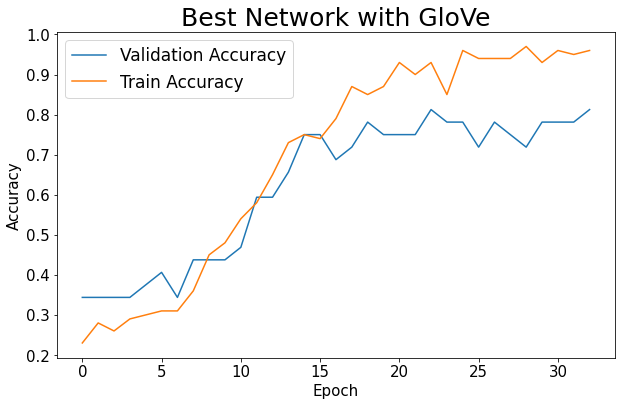

In [53]:
fig = plt.figure(figsize = (10, 6))
_ = plt.plot(training.history['val_accuracy'])
_ = plt.plot(training.history['accuracy'])
_ = plt.xlabel('Epoch', fontsize = 15)
_ = plt.ylabel('Accuracy', fontsize = 15)
_ = plt.yticks(fontsize = 15)
_ = plt.xticks(fontsize = 15)
_ = plt.legend(['Validation Accuracy','Train Accuracy'], fontsize = 17)
_ = plt.title('Best Network with GloVe', fontdict = {'fontsize' : 25})

In [54]:
print('The train accuracy is ' + str(training.history['accuracy'][-1]))
print('The validation accuracy is ' + str(training.history['val_accuracy'][-1]))

The train accuracy is 0.9599999785423279
The validation accuracy is 0.8125


#### Changing dropout rate

In [55]:
def create_model7(dropout_rate):
    model = Sequential()
    model.add(Dense(64, input_dim = 250, activation = 'relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(5, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

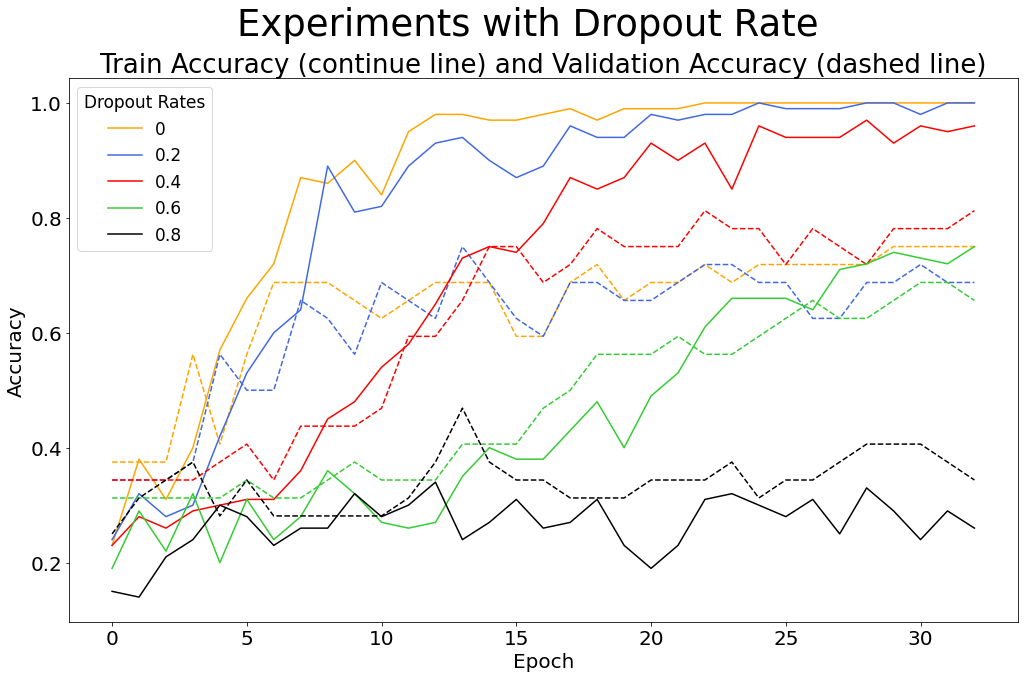

In [56]:
rates = [0, 0.2, 0.4, 0.6, 0.8]
colors = ['orange', 'royalblue','red',  'limegreen', 'black']
accuracies7 = {}


from matplotlib.lines import Line2D
lines = [Line2D([0], [0], color='orange'),
        Line2D([0], [0], color='royalblue'),
        Line2D([0], [0], color='red'),
        Line2D([0], [0], color='limegreen'),
        Line2D([0], [0], color='black')]
fig, ax = plt.subplots(figsize = (17, 10))
for rate in rates:
    tf.random.set_seed(1234)
    model = create_model7(rate)
    training = model.fit(X_train_gv,y_train2, validation_data=(X_val_gv, y_val2), epochs = 33, verbose = 0, batch_size = 32)
    accuracies7[rate] = {'accuracy': training.history['accuracy'],'val_accuracy': training.history['val_accuracy']}
    _ = plt.plot(accuracies7[rate]['accuracy'], color = colors[rates.index(rate)])
    _ = plt.plot(accuracies7[rate]['val_accuracy'], '--', color = colors[rates.index(rate)])

_ =ax.legend(lines, rates, title = 'Dropout Rates',title_fontsize= 17, fontsize = 17)

_ = plt.xlabel('Epoch', fontsize = 20)
_ = plt.ylabel('Accuracy', fontsize = 20)
_ = plt.yticks(fontsize = 20)
_ = plt.xticks(fontsize = 20)
_ = plt.suptitle('Experiments with Dropout Rate', fontsize = 37) #fontdict = {'fontsize' : 35}
_ = plt.title('Train Accuracy (continue line) and Validation Accuracy (dashed line)', fontsize = 26)

The model with the best accuracy and less overfitting is the one with the dropout rate equal to 0.4

In [57]:
# Prediction on the validation set
y_pred = best_model.predict(X_val_gv)
y_pred = [np.argmax(row) for row in y_pred]

In [58]:
### Best Network found with GloVe and Standardization

tf.random.set_seed(1234)
best_model_std = create_model5(256, 64, 1024, 'relu')
training2 = best_model_std.fit(X_train_std,y_train2, validation_data=(X_val_std, y_val2), epochs= 36, verbose = 0, batch_size = 32)

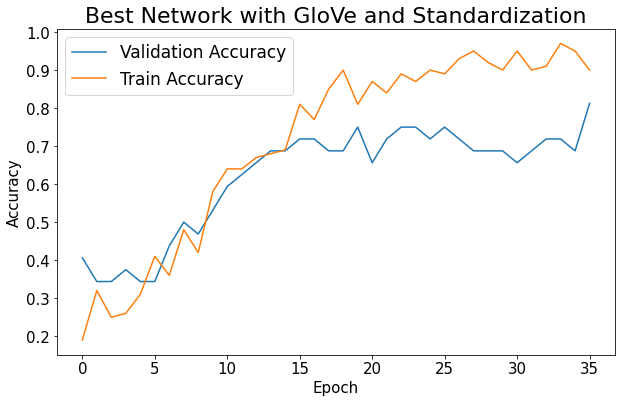

In [59]:
fig = plt.figure(figsize = (10, 6))
_ = plt.plot(training2.history['val_accuracy'])
_ = plt.plot(training2.history['accuracy'])
_ = plt.xlabel('Epoch', fontsize = 15)
_ = plt.ylabel('Accuracy', fontsize = 15)
_ = plt.yticks(fontsize = 15)
_ = plt.xticks(fontsize = 15)
_ = plt.legend(['Validation Accuracy','Train Accuracy'], fontsize = 17)
_ = plt.title('Best Network with GloVe and Standardization', fontdict = {'fontsize' : 22})

In [60]:
print('The train accuracy is ' + str(training2.history['accuracy'][-1]))
print('The validation accuracy is ' + str(training2.history['val_accuracy'][-1]))

The train accuracy is 0.8999999761581421
The validation accuracy is 0.8125


In [61]:
# Prediction on the validation set
y_pred_std = best_model_std.predict(X_val_std)
y_pred_std = [np.argmax(row) for row in y_pred_std]

In [62]:
# The prediction on the validation set is almost the same for the 2 models
accuracy_score(y_pred, y_pred_std)

0.9375

In [63]:
# Prediction on the test set
y_test_pred1 = best_model.predict(X_test_gv)
y_test_pred1 = [np.argmax(row) for row in y_test_pred1]

y_test_pred2 = best_model_std.predict(X_test_gv)
y_test_pred2 = [np.argmax(row) for row in y_test_pred2]

In [64]:
# The prediction on the test set is the same for the 2 models (standardaized or not)
accuracy_score(y_test_pred1, y_test_pred2)
1.0

1.0

# Conclusions 

Here are the best **test accuracies**, obtained submitting our test prediction on Kaggle: <br>
*1)* Logistic Regression ---------> 0.67857 <br>
*2)* Linear SVM ------------------> 0.678565 <br>
*3)* Neural Networks - TFIDF ---> 0.66071 <br>
*4)* Neural Networks - GloVe ---> 0.64285 <br>

Even if we focused on Neural Networks the best test accuracy was not achieved with them, but using Logistic Regression with TF-IDF: it is interesting to notice that the best model is neither given by the most complex classifier nor by the most sophisticated vectorization.